In [22]:
import os
import requests
import datetime as dt
from bs4 import BeautifulSoup
from collections import defaultdict
from funcy import walk_values, join, flatten, first, rest
import pickle

In [23]:
import pandas as pd
import numpy as np

try:
    import plotly.plotly as py
    import plotly.graph_objs as go
    import cufflinks as cf
except:
    !pip install plotly
    !pip install cufflinks

In [24]:
# do not share this work with plot.ly
# cf.go_offline()

In [25]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

# optional formatting changes
pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:20,.2f}'.format

## Pull data from CMC

In [26]:
from src.markets import *

In [27]:
refresh_data()  # warn: this will take a while

In [28]:
historic_data = read_historic_data()
len(historic_data)

202731

## Pandas Helpers

In [29]:
def create_daily_df(data):
    """ Take a flat list of hourly prices, 
    and resample it into a single dataframe with daily averages.
    """
    data2 = defaultdict(list)
    for fragment in data:
        data2[fragment['symbol']].append(fragment)
        
    main_df = pd.DataFrame()
    for symbol, data in data2.items():
        # resample into daily data
        df = pd.DataFrame(data)
        df.set_index('timestamp', inplace=True)
        df = df.resample('1d').mean()
        df.reset_index(inplace=True)
        df['symbol'] = np.repeat(symbol, len(df))
#         df['category'] = np.repeat(data[0]['category'], len(df))

        # join into main df
        if main_df.empty:
            main_df = df
        else: 
            main_df = main_df.append(df)
            
    return main_df

def price_matrix(historic_data, min_date=None):
    """ Create a USD Price Matrix from historic data.
    
    Take a flat list of hourly prices. Remove everything but USD price.
    Resample into Daily prices based on `last` price.
    If min_date is present, exclude all coins that start trading after that date.
    
    Warning: 
       This will drop dates when ALL coin prices are not available.
       Shrink historic data universe to avoid this problem.
    """
    if len(first(historic_data).keys()) != 3:
        historic_data = simplify_hist_data(historic_data)
    
    data2 = defaultdict(list)
    for fragment in historic_data:
        data2[fragment['symbol']].append(fragment)
        
    main_df = pd.DataFrame()
    for symbol, data in data2.items():
        # resample into daily data
        df = pd.DataFrame(data)
        
        first_available_date = df.sort_values('timestamp').iloc[0].get('timestamp', dt.date.today())
        if min_date and first_available_date > min_date:
            continue
        df.set_index('timestamp', inplace=True)
        df = df.resample('1D').last().dropna().reset_index()
        df = df.drop('symbol', axis=1)
        df.columns = ['timestamp', symbol]

        # join into main df
        if main_df.empty:
            main_df = df
        else: 
            main_df = pd.merge(main_df, df, on='timestamp')
            
    if main_df.empty:
        raise ValueError("No items to display. Make sure your min_date is correct.")
            
    return main_df.set_index('timestamp')

def relative_change(df):
    """ Takes a dataframe of prices and computes a relative day-to-day % change."""
    # (yesterday vs today)
    df_rel = df.apply(lambda x: (x/x.shift(1)-1)*100).dropna()
    return df_rel.apply(np.cumsum).dropna()

def absolute_change(df):
    """ Takes a dataframe of prices and computes an absolute change from day 0."""
    # (day 0 vs today)
    df_abs = df.apply(lambda x: (x/x.iloc[0]))
    return df_abs

def normalize_against(df_ret, benchmark='BTC'):
    """ Takes a dataframe of prices and subtracts benchmark movement from other coins."""
    return df_ret.apply(lambda x: (x-x[benchmark]), axis=1)

## Universe a while ago

In [30]:
def top_coins_on_dt(datum=None, limit=100):
    """Return top 100 coins on X date in the past."""
    if not datum:
        datum = dt.date.today()
    w_date = [{**x, 'date': x['timestamp'].date()} for x in historic_data]
    dft = pd.DataFrame(w_date)
    dft = dft[dft.date == datum]
    dft.set_index('position', inplace=True)
    dft.drop_duplicates('symbol', inplace=True)
    dft.drop(['date', 'timestamp'], axis=1, inplace=True)
    return dft[dft.index<limit].sort_index()

In [31]:
top_coins_on_dt(dt.date(2016, 10, 10)).head(3)

,cap_btc,cap_usd,category,change_1d,change_1h,change_7d,price_btc,price_usd,supply,symbol,volume_btc
position,,,,,,,,,,,
1,15914088,9818562616,currency,-0.29,-0.00,1.02,1.00,616.97,15914088,BTC,61544
2,1658305,1023235446,currency,-1.07,0.07,-8.63,0.02,12.07,84806014,ETH,11935
3,432908,267120728,currency,3.14,-0.04,-7.72,0.00,0.01,35475802044,XRP,5490


## ETH, STEEM, XMR vs Bitcoin

In [32]:
hd_simple = simplify_hist_data(historic_data)

In [33]:
universe = ['BTC', 'STEEM', 'ETH', 'XMR', 'DASH', 'XRP', 'NEM']
# universe = top_coins_on_dt(dt.date(2017, 6, 8), limit=100).symbol.tolist()

In [34]:
hd_sample = [x for x in hd_simple if x['symbol'] in universe]

In [35]:
# this year only
df = price_matrix(hd_sample, min_date=dt.datetime(2017, 1, 1))

In [36]:
df['BTC'].head()

timestamp
2016-04-26                 464.07
2016-04-27                 466.29
2016-04-28                 449.37
2016-04-29                 448.26
2016-04-30                 454.61
Name: BTC, dtype: float64

In [37]:
# turn usd prices in % changes

In [38]:
df_ret = absolute_change(df)

In [39]:
df_ret.head()

,BTC,DASH,ETH,STEEM,XMR,XRP
timestamp,,,,,,
2016-04-26,1.00,1.00,1.00,1.00,1.00,1.00
2016-04-27,1.00,0.97,1.01,1.20,0.92,0.98
2016-04-28,0.97,1.03,1.07,1.14,1.01,0.93
2016-04-29,0.97,1.02,1.00,1.14,0.95,0.92
2016-04-30,0.98,1.06,1.03,1.18,0.93,0.93


In [40]:
df_ret.iplot(title='Return Multiplier', theme='white')

In [41]:
#df_ret.apply(lambda x: x*1000).iplot(title='$1000 USD Invested')

In [42]:
normalize_against(df_ret, 'BTC').apply(lambda x: x*1000).iplot(title='$1000 USD Invested, -Benchmark [BTC]', theme='white')
#normalize_against(df_ret, 'BTC').iplot(title='Return vs Benchmark')

In [43]:
# same as above
#df_ret_norm = normalize_against(df_ret, 'BTC')
#df_ret_norm.apply(lambda x: x*100).iplot(title='% Performance vs Benchmark [BTC]')

In [44]:
#pct_gain_loss(df_ret).iplot(title='% Gained or Lost')

## Latest Percent Changes

In [45]:
def historic_data_for_coins(symbols=['BTC', 'ETH', 'XMR', 'DASH']):
    """Return historic data for a list of coins."""
    data = simplify_hist_data(historic_data)
    return (x for x in data if x['symbol'] in symbols)

def usd_pct_change(period=7, universe=['BTC', 'ETH', 'XMR', 'DASH']):
    """Rank coins by gains/losses for trailing X days."""
    df = price_matrix(historic_data_for_coins(universe))
    latest = df.pct_change(periods=period).tail(1)*100
    latest = latest.transpose()
    ranking = pd.Series(latest.values.tolist(), index=latest.index.values)
    return ranking.sort_values(ascending=False)

In [46]:
universe = ['BTC', 'ETH', 'XMR', 'DASH', 'BTS']
universe = top_coins_on_dt(dt.date(2017, 6, 10), limit=15).symbol.tolist()
usd_pct_change(period=30, universe=universe)

BTS       [937.8443968977097]
BCN      [506.52181239152776]
STRAT     [490.5122188702134]
SC       [475.07072792978835]
WAVES    [354.52972659712276]
ETH      [332.67657799048146]
ETC      [220.15984281152438]
STEEM    [182.88300164922825]
DASH       [90.4396742387529]
XMR       [76.50454171552585]
XEM       [55.49513758934872]
BTC       [49.19574044452399]
XRP       [18.75693933672824]
LTC       [4.021898454746142]
dtype: object

In [47]:
# look at 7 day pct change from top 100 coins (recent)
cmc_today = top_coins_on_dt(limit=100)
if len(cmc_today):
    res = usd_pct_change(period=16, universe=cmc_today.symbol.values.tolist())

## Had I invested 100 USD in every top 100 coin a year ago

In [48]:
main_df = create_daily_df(historic_data)

In [49]:
# now we can group by symbol or day
# main_df.groupby('symbol').describe()
# main_df.groupby('timestamp').describe()

# df['returns'] = np.log(df['price_usd'] / df['price_usd'].shift(1))
# df['pos_change'] = (df['position'] - df['position'].shift(1))
# df.dropna(inplace=True)

In [50]:
from random import sample
from contextlib import suppress

def top_coins_on(datestring = '2016-04-10', limit=None):
    df_sorted = main_df[(main_df['timestamp'] == datestring) & (main_df['position'] < 200)].sort_values('position')
    if limit:
        df_sorted = df_sorted[:limit]
    return df_sorted[['price_usd', 'symbol']]

def portfolio_on(symbols, datestring, limit=None):
    df = top_coins_on(datestring)
    df_sorted = df[df['symbol'].isin(symbols)]
    return df_sorted[['price_usd', 'symbol']]

def monkey_pick(datestring = '2016-04-10'):
    df = top_coins_on(datestring)
    return sample(df.symbol.values.tolist(), 10)

def eval_portfolio(initial_datestring = '2016-04-10', symbols=None, invest_amt = 100):
    results = []
    for i in range(365, 7, -7):
        ts = dt.date.strftime(dt.date.today() - dt.timedelta(days=i), '%Y-%m-%d')

        with suppress(Exception):
            # if we provided our own porfolio evaluate it
            # otherwise pick top coins from initial_datestring
            if symbols:
                test = portfolio_on(symbols, initial_datestring)
            else:
                test = top_coins_on(initial_datestring, 100)
                
            test['qty'] = test.apply(lambda x: invest_amt / x['price_usd'], axis=1)  # invest $100 in each coin

            if symbols:
                test2 = portfolio_on(symbols, ts)
            else:
                test2 = top_coins_on(ts, None)

            test3 = test.merge(test2, on='symbol')
            test3['value'] = test3.apply(lambda x: x['qty']*x['price_usd_y'], axis=1)
            results.append((ts, test3['value'].sum()))
    return results
            
def show_results(results, title='Results'):
    df = pd.DataFrame(results, columns=['date', 'value'])
    df.set_index('date', inplace=True)
    df.plot(title=title)
    plt.grid()

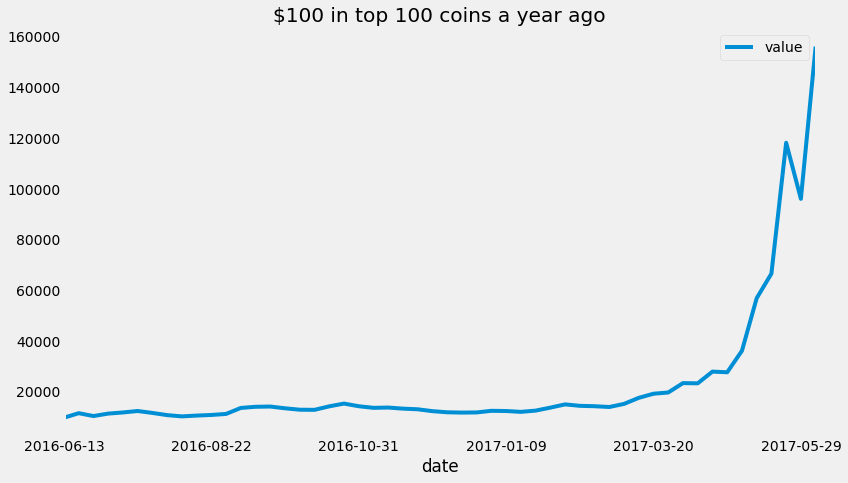

In [51]:
# top coins portfolio
show_results(eval_portfolio(), title='$100 in top 100 coins a year ago')

In [52]:
# random portfolio
# show_results(eval_portfolio(symbols=monkey_pick(), invest_amt = 1000), title='$1,000 in random 10 coins a year ago')

In [53]:
from toolz.curried import get

def random_portfolios(num_portfolios = 10):
    results = [eval_portfolio(symbols=monkey_pick(), invest_amt = 1000) for x in range(num_portfolios)]
    
    df = pd.DataFrame()
    df['date'] = list(map(get(0), results[0]))
    for i, result_set in enumerate(results, 1):
        df[i] = list(map(get(1), result_set))

    df.set_index('date', inplace=True)
    return df

In [54]:
df = random_portfolios(15)

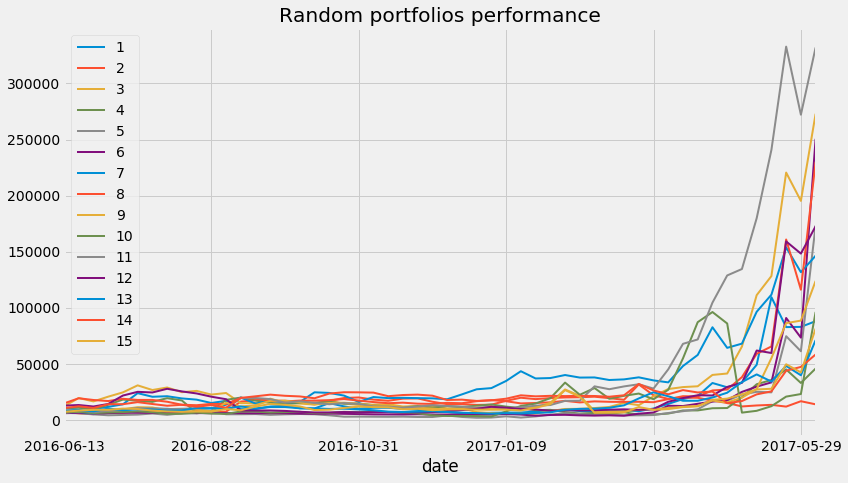

In [55]:
df.plot(linewidth=2, title='Random portfolios performance')

## Percent Gain/Loss

In [56]:
historic_data[0]

{'cap_btc': 2,
 'cap_usd': 968,
 'category': 'currency',
 'change_1d': 25.81,
 'change_1h': 25.08,
 'change_7d': 0.2,
 'position': 552,
 'price_btc': 4.99953e-08,
 'price_usd': 2.10948e-05,
 'supply': 45887218,
 'symbol': '$$$',
 'timestamp': datetime.datetime(2016, 4, 10, 16, 0, 2),
 'volume_btc': 0}

In [57]:
def create_pct_change_df(data, date=None):
    """ Take a flat list of hourly prices, 
    and resample it into a single dataframe with daily averages.
    """
    data2 = defaultdict(list)
    for fragment in data:
        if date and fragment['timestamp'].date() != date:
            continue
        data2[fragment['symbol']].append(fragment)
        
    main_df = pd.DataFrame()
    for symbol, data in data2.items():
        # resample into daily data
        df = pd.DataFrame(data)
        latest_item = df.sort_values('timestamp', ascending=False).iloc[0]
        main_df = main_df.append(latest_item)
          
    main_df['position'] = main_df['position'].apply(int)
    main_df.set_index('position', inplace=True)
    return main_df[[
        'symbol', 'volume_btc',
        'cap_btc', 'cap_usd',
        'change_1h', 'change_1d', 'change_7d',
        'price_usd', 'price_btc']]

In [58]:
df = create_pct_change_df(historic_data)

In [59]:
# don't look at coins with less than 1MM in mkt_cap
df2 = df[((df.cap_usd > 1_000_000) & (df.index > 10) & (df.index < 130))]

In [60]:
df2.sort_values('change_7d', ascending=False).head(100)

,symbol,volume_btc,cap_btc,cap_usd,change_1h,change_1d,change_7d,price_usd,price_btc
position,,,,,,,,,
128,ECC,35.00,"3,971.00","10,493,547.00",41.90,125.70,"1,684.34",0.00,0.00
99,MUSE,13.00,"6,360.00","16,807,425.00",4.19,111.48,245.31,0.01,0.00
93,AEON,104.00,"7,174.00","18,958,754.00",10.19,55.73,163.17,1.33,0.00
104,JINN,1.00,"5,726.00","15,131,696.00",3.88,39.05,108.41,257.77,0.10
18,LSK,"6,152.00","140,655.00","371,693,506.00",8.16,-11.98,108.08,3.43,0.00
29,NXT,"18,482.00","65,693.00","173,599,224.00",4.93,21.88,105.63,0.17,0.00
105,XAS,207.00,"5,669.00","14,981,250.00",0.02,-10.04,102.60,0.20,0.00
85,NOTE,689.00,"8,882.00","23,472,764.00",0.12,-17.50,101.88,0.19,0.00
122,WDC,409.00,"4,334.00","11,453,256.00",-1.14,-8.02,86.24,0.10,0.00


## Naive Trading Strategy
We rebalance our portfolio weekly.

Rules:
 - we can not initially buy more than 10,000 worth of coins
 - with each sell/trade, we re-calculate balance
 - no trade can be bigger than 1000 USD

Strategy:
 - if a coin goes up 30% or more in a week, buy it
 - if coin goes up 100% from last trade, sell half
 - if coin goes down by 50% in a week, sell all
 
Filters:
 - can't be top 10
 - must be in top 130
 - must have at least 1MM mkt cap

In [245]:
# generate weekly snapshots
rebalances = list()
# day = dt.date(2016, 4, 10)
day = dt.date(2017, 4, 10)
while dt.date.today() > day: 
    _df = create_pct_change_df(historic_data, date=day)
    rebalances.append(_df)
    day += dt.timedelta(days=7)

In [246]:
len(rebalances)

24

In [247]:
#df.sort_values('cap_usd', ascending=False).head()

In [248]:
# vars
budget = 10000
pos_limit = 1000
fees = 0.02  # very conservative 2% fees (realistically its 0.25% + slippage)

# filters
qualified = lambda df: df[((df.cap_usd > 1_000_000) & (df.index > 10) & (df.index < 130))]
to_buy = lambda df: df[(df.change_7d) > 30]
to_sell = lambda df: df[(df.change_7d) < -50]

# helpers
sort_winners = lambda df, limit: df.sort_values('change_7d', ascending=False).head(limit)
sort_losers = lambda df, limit: df.sort_values('change_7d').head(limit)

# operations
merge_portfolio = lambda df, portfolio: pd.merge(df, portfolio, on='symbol', how='inner')
in_portfolio = lambda df, portfolio: df[df.symbol.isin(portfolio.symbol.tolist())]
not_in_portfolio = lambda df, portfolio: df[~df.symbol.isin(portfolio.symbol.tolist())]

In [249]:
sort_winners(to_buy(qualified(rebalances[0])), 10)

,symbol,volume_btc,cap_btc,cap_usd,change_1h,change_1d,change_7d,price_usd,price_btc
position,,,,,,,,,
54,VSL,50.00,"2,866.00","2,757,951.00",21.63,38.72,133.60,0.08,0.00
71,AEON,1.00,"1,326.00","1,276,071.00",-0.64,0.33,70.91,0.10,0.00
52,GRC,5.00,"2,951.00","2,839,705.00",10.93,24.00,59.04,0.01,0.00
60,TIPS,4.00,"1,714.00","1,649,578.00",0.01,35.16,57.98,0.00,0.00
59,FAIR,0.00,"1,714.00","1,649,869.00",0.17,3.97,51.69,0.03,0.00
70,NXC,25.00,"1,403.00","1,350,531.00",-1.11,17.95,39.59,0.02,0.00
14,WAVES,49.00,"25,882.00","24,908,300.00",-0.53,8.67,33.32,0.25,0.00
77,AUR,4.00,"1,176.00","1,132,086.00",0.18,17.58,33.07,0.13,0.00


In [250]:
# start trading
balance = budget  # 10,000 USD
portfolio = pd.DataFrame(columns=['symbol', 'trade_price_usd', 'qty'])

def trade(buy=None, sell=None):
    global portfolio
    global balance
    
    # init values
    if type(buy) == type(None):
        buy = pd.DataFrame()
        
    if type(sell) == type(None):
        sell = pd.DataFrame()
        
    # sell the losers
    if not sell.empty:
        for i, row in in_portfolio(sell, portfolio).iterrows():
            qty = portfolio[portfolio.symbol == row['symbol']]['qty']
            usd_value = row['price_usd']
            item_value = usd_value * float(qty) * (1-fees)
            balance += item_value     
            # delete sold item
            portfolio = portfolio[portfolio.symbol != row['symbol']]
        
    # handle partial sells
    # todo:
    # merge with price feeds on rebalance date
    # select coins where dt[dt.price_usd > dt.trade_price_usd * 2]
    # sell half of the coins, update portfolio, balance
        
    # buy the winners
    if not buy.empty and balance > 0:
        purchases = not_in_portfolio(buy, portfolio)
        pos_size = balance // len(purchases)
        if pos_size > pos_limit:
            pos_size = pos_limit

        for i, row in purchases.iterrows():
            qty = pos_size/row['price_usd'] * (1-fees)
            portfolio.loc[len(portfolio)] = [row['symbol'], row['price_usd'], qty]
            balance -= pos_size
        
# perform trades
for rebalance in rebalances:
    losers = to_sell(rebalance)
    winners = sort_winners(to_buy(qualified(rebalance)), 100)
    trade(
        sell=losers,
        buy=winners,
    )

In [251]:
def portfolio_value():
    global portfolio
    
    if portfolio.empty:
        return 0
    
    # update our portfolio with todays prices
    cmc_today = top_coins_on_dt(datum=None, limit=1000)
    portfolio_today = merge_portfolio(cmc_today, portfolio) 
    
    return sum(portfolio_today['price_usd'] * portfolio_today['qty'])

In [252]:
# final asset + balance value
portfolio_value() + balance

73815.967945922283